### Deep Learning for ECG Signal Denoising

- Part 1: Explore ECG signals 
- Part 2: Building Models

To start... imports!
-  %pip install library1 library2 .. 

In [1]:
%pip install ssqueezepy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchaudio 
import wfdb
import os
import sys
import wfdb
import numpy as np
import pywt
import random
import string
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import stft
from wfdb import processing

print('Virtual Environment:')
print(sys.prefix)


Virtual Environment:
/Users/piedeboer/Desktop/Thesis/code/signal-denoising/venv


### Part 1: Exploring ECG signals

- work with wfdb to visualize ecg signals and detect QRS complexes
- generate scalograms and spectograms
- encoding time series for deep learning
- generate noisy samples
- build train/test set


#### Load ECG signals with WFDB and detect QRS complexes

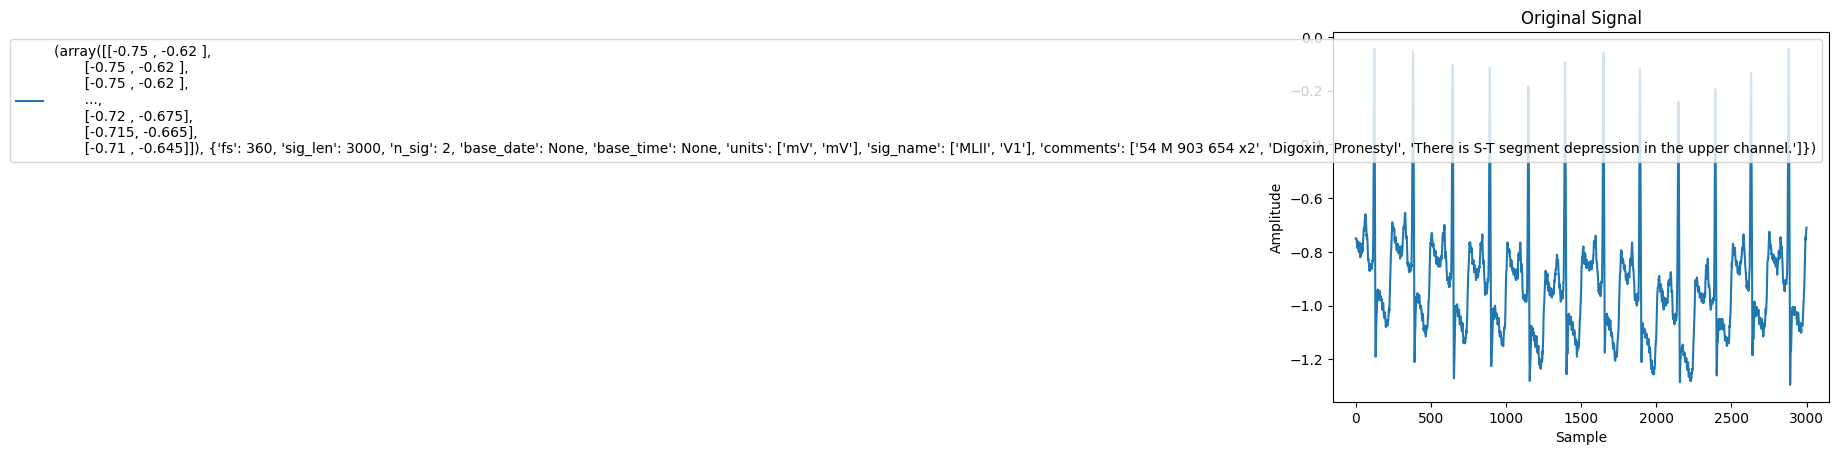

In [3]:
# Path to individual ecg file
path_102 = "data/ardb/112"

# Extract record
record_102 = wfdb.rdsamp(path_102, sampto=3000)

# Extract Lead I ECG signal
signal_102 = record_102[0][:, 0]

plt.plot(signal_102, label=str(record_102))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Original Signal')
plt.legend()
plt.show()

We proceed to extract the QRS complexes, we can use this to create windows to later build the spectograms.

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


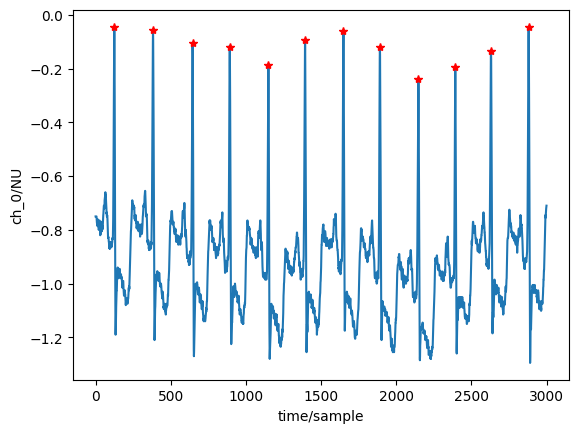

[ 124  382  645  893 1149 1393 1648 1891 2147 2392 2630 2880]


In [4]:
import wfdb
from wfdb import processing

# Load the ECG signal
path_102 = "data/ardb/112"
sig, fields = wfdb.rdsamp(path_102, channels=[0])

# Extract the first 3000 samples of the signal
sig = sig[:3000]

# Initialize the XQRS detector
xqrs = processing.XQRS(sig=sig[:, 0], fs=fields['fs'])

# Detect QRS complexes
xqrs.detect()

# Plot the signal with QRS complex annotations
wfdb.plot_items(signal=sig, ann_samp=[xqrs.qrs_inds])

print(xqrs.qrs_inds)


We can proceed and extract individual heartbeats based on the QRS complexes it is able to find.

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


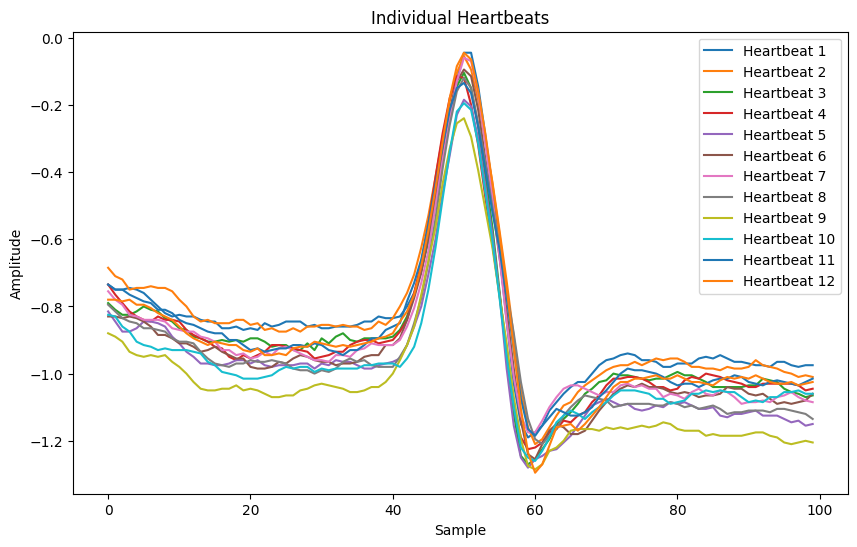

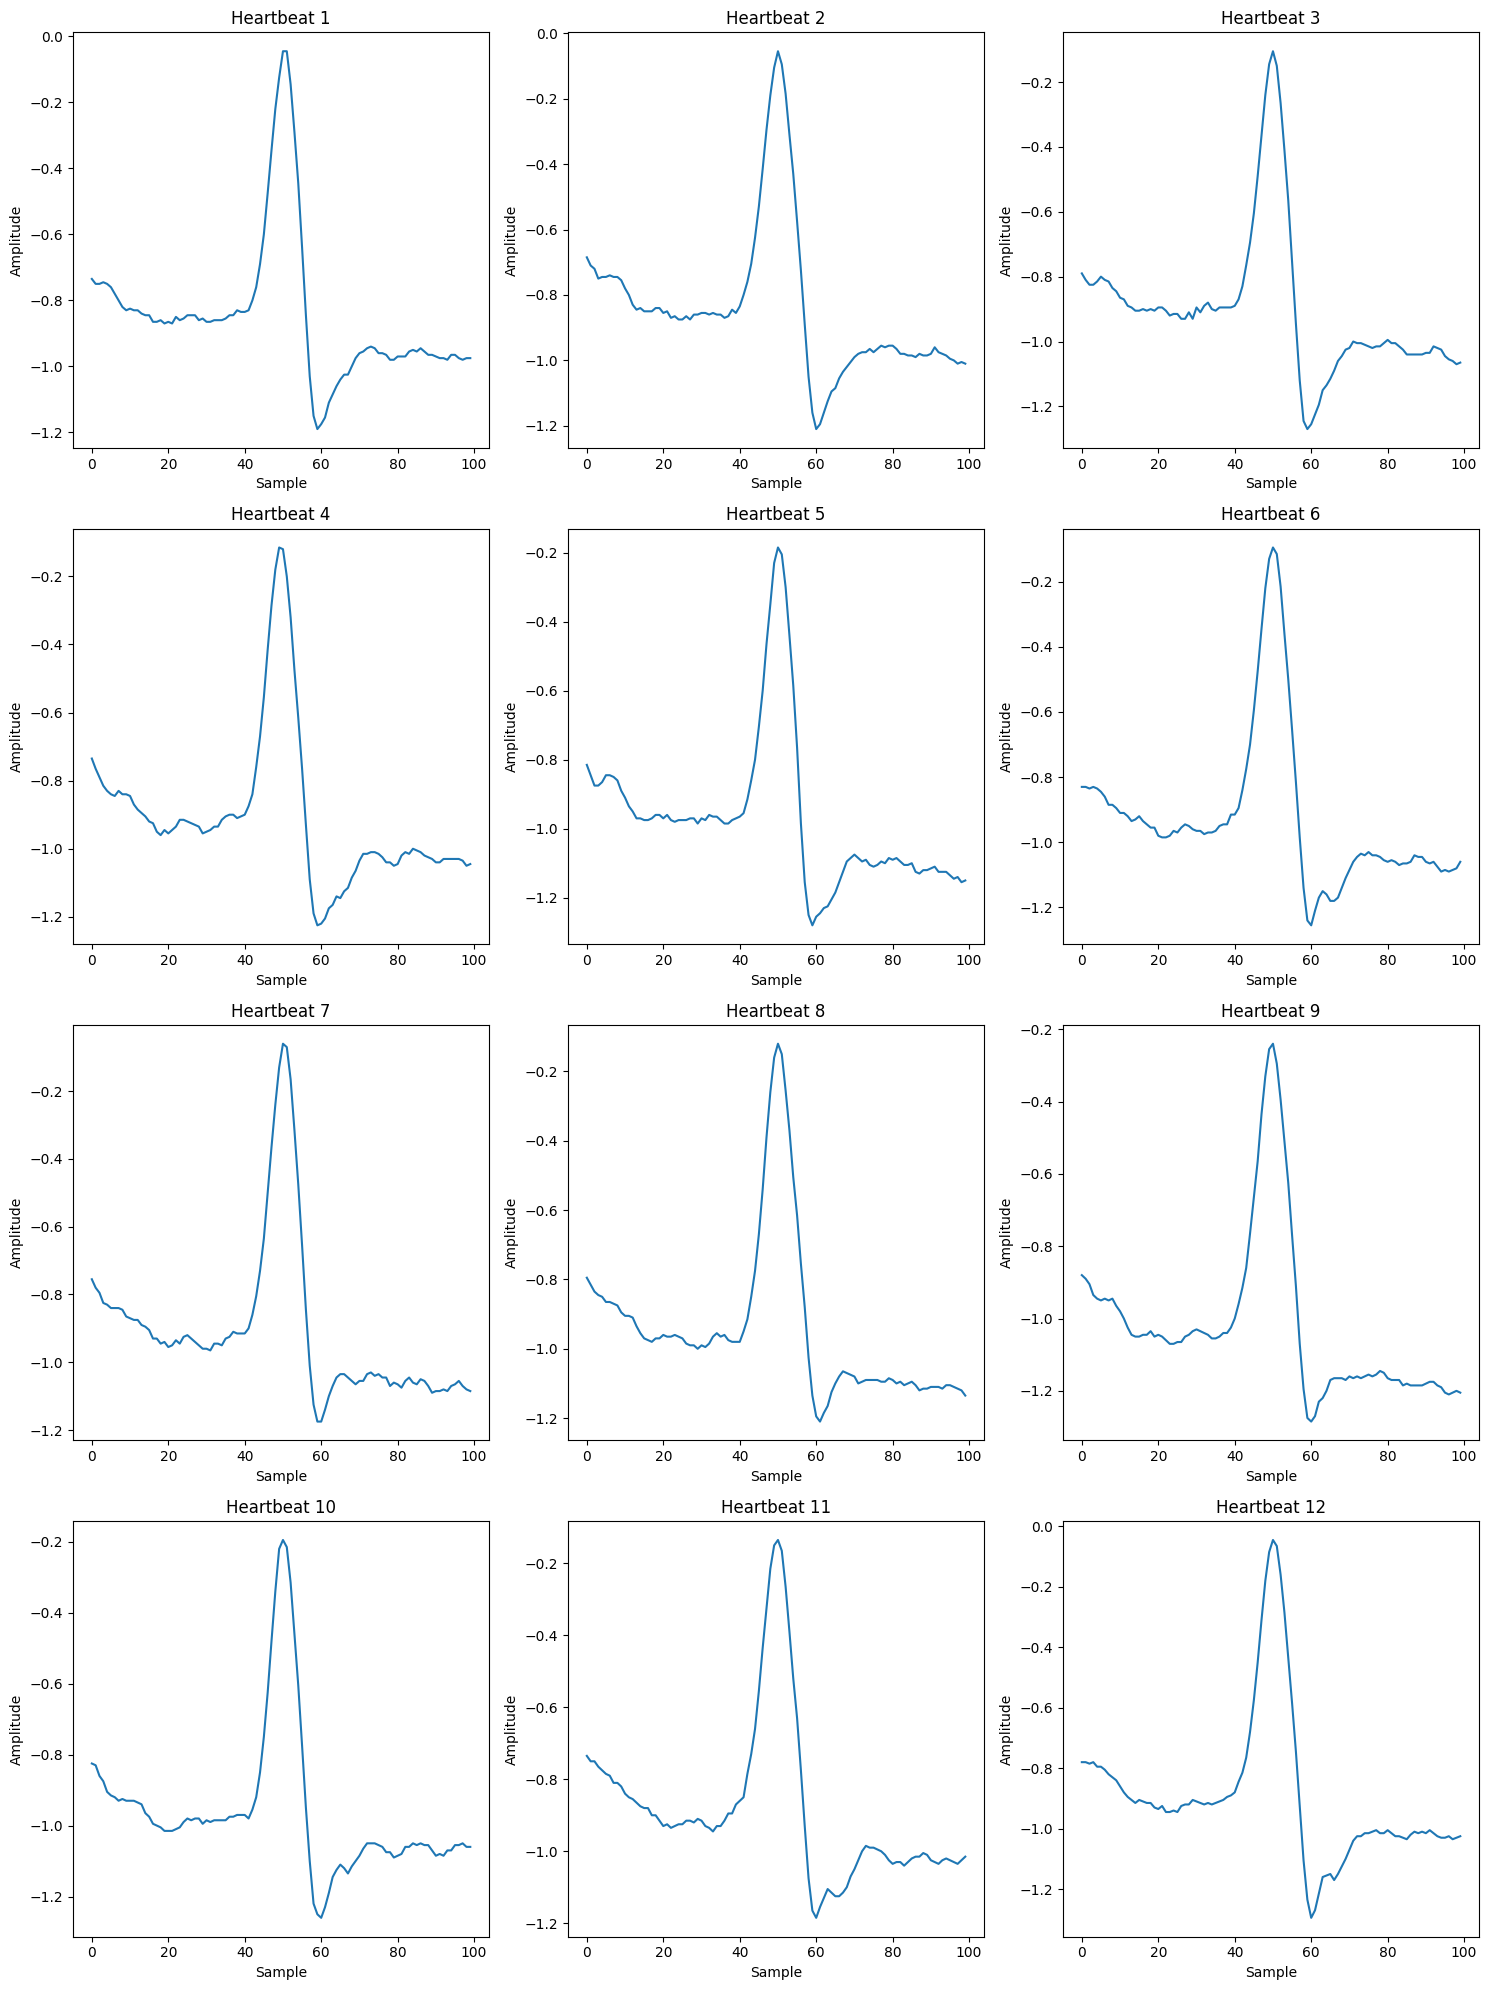

Duration: 8.33 seconds
Average duration of a heartbeat: 0.70 seconds


In [5]:
# Load the ECG signal
# path_102 = "data/ardb/112"
path_102 = "data/ardb/112"
sig, fields = wfdb.rdsamp(path_102, channels=[0])

# Extract the first 3000 samples of the signal
sig = sig[:3000]

# Initialize the XQRS detector
xqrs = processing.XQRS(sig=sig[:, 0], fs=fields['fs'])

# Detect QRS complexes
xqrs.detect()

# Segment the signal around QRS complexes
window_size = 100  # Define the window size around each QRS complex
heartbeats = []
for qrs_index in xqrs.qrs_inds:
    start_index = max(0, qrs_index - window_size // 2)
    end_index = min(len(sig), qrs_index + window_size // 2)
    heartbeat = sig[start_index:end_index]
    heartbeats.append(heartbeat)

sig = heartbeats[1]

# Plot the individual heartbeats
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, heartbeat in enumerate(heartbeats):
    plt.plot(heartbeat, label=f"Heartbeat {i+1}")

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Individual Heartbeats')
plt.legend()
plt.show()

# Plot the individual heartbeats in separate subplots
num_beats = len(heartbeats)
num_cols = 3  # Define the number of columns for subplots
num_rows = (num_beats + num_cols - 1) // num_cols  # Calculate the number of rows

plt.figure(figsize=(15, 5*num_rows))
for i, heartbeat in enumerate(heartbeats):
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(heartbeat)
    plt.title(f"Heartbeat {i+1}")
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Duration
sampling_frequency = 360
num_samples = 3000
duration = num_samples / sampling_frequency

print(f"Duration: {duration:.2f} seconds")

# Calculate the intervals between consecutive QRS complexes
qrs_intervals = np.diff(xqrs.qrs_inds) / fields['fs']  # Convert samples to seconds

# Calculate the average duration of a heartbeat
avg_heartbeat_duration = np.mean(qrs_intervals)

print(f"Average duration of a heartbeat: {avg_heartbeat_duration:.2f} seconds")

#### Generate Scalograms and Spectograms

In comparison to Matlab, pwts does not come with an icwt method. Therefore, the original pwts implementation is moved to src folder. Because of this issue, we used an alternative library https://github.com/OverLordGoldDragon/ssqueezepy?tab=readme-ov-file. The starter code is taken from: https://dsp.stackexchange.com/questions/87097/why-is-inverse-cwt-inexact-inaccurate. Read more about cwt, dwt and stft here: https://dsp.stackexchange.com/questions/76624/continuous-wavelet-transform-vs-discrete-wavelet-transform. 

In [6]:
# Load record
samples = 128*4 ; Fs=360
record = wfdb.rdsamp('data/nstdb/em', sampto=samples)   # extract first ... samples
I = record[0][:, 0]                                     # extract first lead

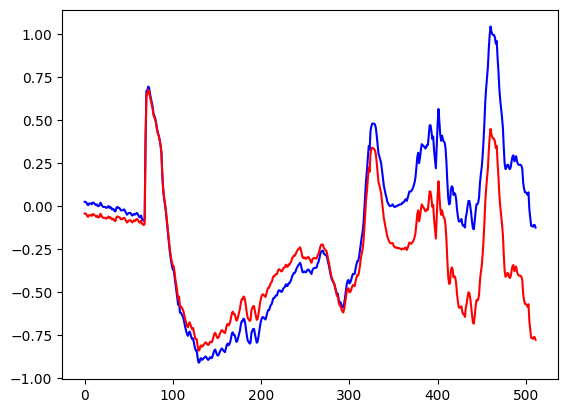

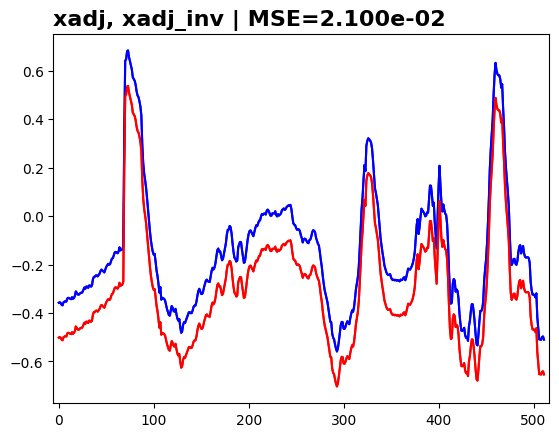

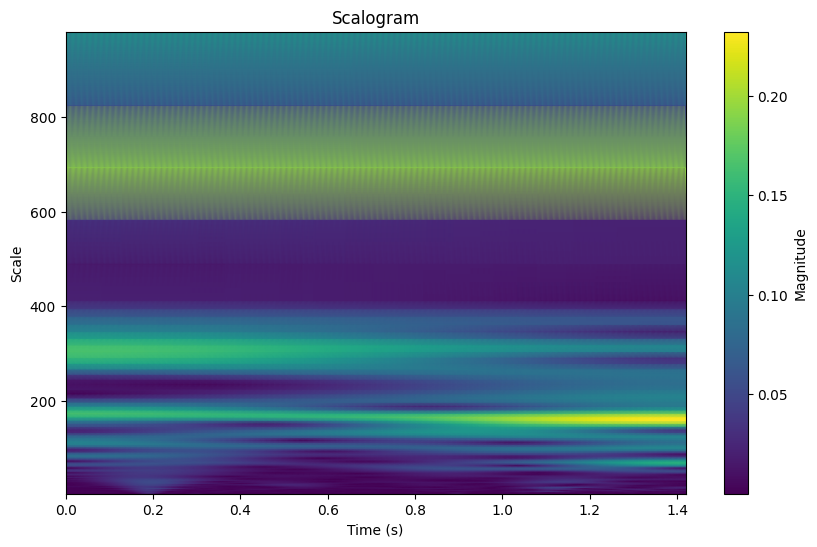

In [7]:
import numpy as np
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt
from ssqueezepy import cwt, icwt, Wavelet, padsignal
from ssqueezepy.visuals import plot, plotscat

# ************************************
# ************************************
# Code adapted from: 
# https://dsp.stackexchange.com/questions/87097/why-is-inverse-cwt-inexact-inaccurate.

wavelet = Wavelet('morlet')
nv = 16

n = 100; t=samples; x=I; x_mean = x.mean()

plt.plot(x,color='b')

Wx, scales = cwt(x, wavelet=wavelet, nv=nv)
x_inv = icwt(Wx, wavelet=wavelet, nv=nv, x_mean=x_mean)

plt.plot(x_inv,color='r')
plt.show()

#%%
xf = rfft(x)
xf[1:3] = 0
xadj = irfft(xf)
x_mean = xadj.mean()

Wx, scales = cwt(xadj, wavelet=wavelet, nv=nv, padtype=None)
x_inv = icwt(Wx, wavelet=wavelet, scales=scales, nv=nv, x_mean=x_mean)

plot(xadj, color='b')
plot(x_inv, color='r', title="xadj, xadj_inv | MSE=%.3e" % np.mean((xadj-x_inv)**2))
plt.plot(xadj, color='b')
plt.plot(x_inv, color='r')
plt.show()

#%%
# psis = wavelet._Psih
# pkw = dict(w=.6, h=.8)
# plot(psis.T, color='tab:blue', show=1, **pkw, title="Filterbank, real part")

# eos_tfn = np.sum(psis, axis=0)**2
# plotscat(eos_tfn, show=1, **pkw, title='Energy of Signal "transfer function"')

# xp = padsignal(x, 'reflect')
# plotscat(rfft(xp), abs=1, show=1, **pkw, title="|rfft(x_padded)|")

# Embed/De-embed Methods
def ecg_to_scalogram(x):
    # Compute CWT
    Wx, scales = cwt(x, wavelet=wavelet, nv=nv)

    return np.abs(Wx), scales  # Return the scalogram and scales

def scalogram_to_ecg(Wx, scales, x_mean):
    # Reconstruct signal from scalogram
    x_inv = icwt(Wx, wavelet=wavelet, scales=scales, nv=nv, x_mean=x_mean)
    return x_inv

# Visualizations
def plot_scalogram(x, Fs):
    # Compute CWT
    Wx, scales = cwt(x, wavelet=wavelet, nv=nv)

    # Get time array
    t = np.arange(len(x)) / Fs

    # Plot scalogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, scales, np.abs(Wx), shading='gouraud')
    plt.ylabel('Scale')
    plt.xlabel('Time (s)')
    plt.title('Scalogram')
    plt.colorbar(label='Magnitude')

    # Show plot
    plt.show()

def plot_multiple_scalograms(signals, Fs_list, names):
    num_signals = len(signals)
    num_rows = 1
    num_cols = num_signals
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_signals, 4))

    for i, (signal, Fs, name) in enumerate(zip(signals, Fs_list, names)):
        ax = axs[i] if num_signals > 1 else axs
        
        # Compute CWT
        Wx, scales = cwt(signal, wavelet=wavelet, nv=nv)

        # Get time array
        t = np.arange(len(signal)) / Fs

        # Plot scalogram
        im = ax.pcolormesh(t, scales, np.abs(Wx), shading='gouraud')
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time (s)')
        ax.set_title(name)
        fig.colorbar(im, ax=ax, label='Magnitude')

    plt.tight_layout()
    plt.show()
    
# Assuming you have the signal x and its sampling frequency Fs defined earlier
plot_scalogram(x, Fs)


The stft we take using pytorch methods. We can learn about the parameters to choose here: https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

This paper used pytrochaudio with STFT and ISTFT to generate synthetic ECG with diffusion models: https://arxiv.org/pdf/2306.01875.pdf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time Series


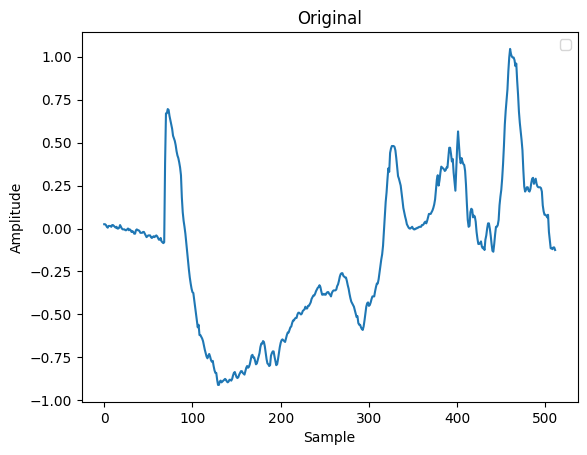

STFT


/Users/piedeboer/Desktop/Thesis/code/signal-denoising/venv/lib/python3.12/site-packages/torch/functional.py:660: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:843.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


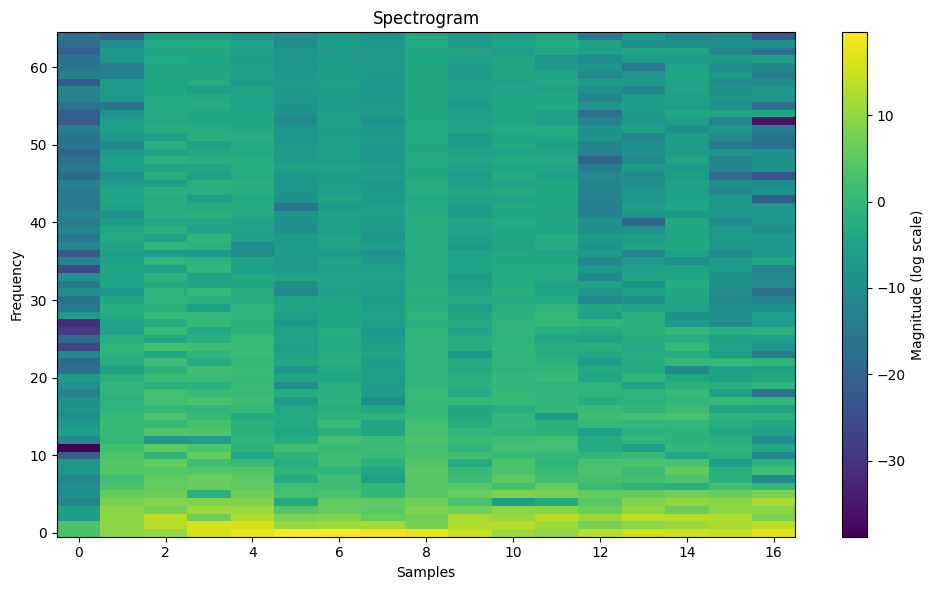

/var/folders/lx/47469rq12_q21sc9r48mg4sc0000gn/T/ipykernel_4486/902961245.py:11: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:1029.)
  I = torch.istft(stft, n_fft=128, center=True, normalized=False, onesided=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ISTFT


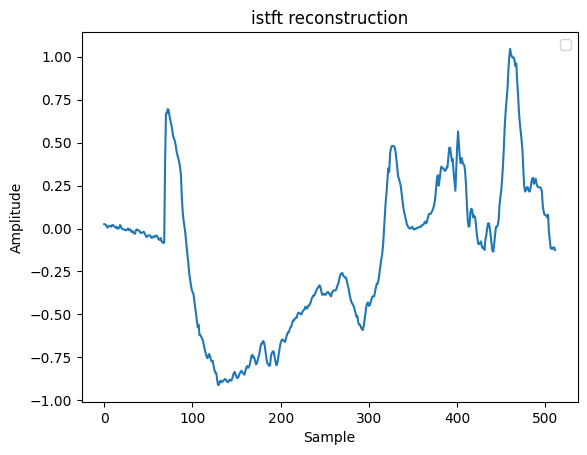

Mean Absolute Error (MAE) between original and reconstructed signal: 4.650198270169561e-19


In [8]:
# Embed/De-embed methods
def generate_stft(I): 
    # Convert the NumPy array I to a PyTorch tensor
    I_tensor = torch.tensor(I)
    # Compute the STFT
    stft = torch.stft(I_tensor, n_fft=128, center=True, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)    
    return stft

def generate_istft(stft):
    # Compute the ISTFT
    I = torch.istft(stft, n_fft=128, center=True, normalized=False, onesided=True)
    return I

def ecg_to_spectrogram(ecg_signal):
    # Generate STFT of ECG signal
    stft = generate_stft(ecg_signal)
    
    # Compute magnitude spectrogram
    magnitude = torch.abs(stft)
    log_magnitude = 10 * np.log10(magnitude)
    
    return log_magnitude

def spectrogram_to_ecg(spectrogram):
    # Generate ISTFT from spectrogram
    stft = torch.pow(10, spectrogram / 10)  # Convert log scale back to linear scale
    ecg_signal = generate_istft(stft)
    
    return ecg_signal

# Visualization Method
def plot_spectrogram(stft): 
    # Compute the magnitude spectrogram
    magnitude = torch.abs(stft)
    log_magnitude = 10 * np.log10(magnitude)
    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(log_magnitude, aspect='auto', origin='lower')
    plt.title('Spectrogram')
    plt.xlabel('Samples')
    plt.ylabel('Frequency')
    plt.colorbar(label='Magnitude (log scale)')
    plt.tight_layout()
    plt.show() 

def plot_multiple_spectrograms(stfts, names):
    num_stfts = len(stfts)
    plt.figure(figsize=(10 * num_stfts, 6))

    for i, (stft, name) in enumerate(zip(stfts, names), 1):
        # Compute the magnitude spectrogram
        magnitude = torch.abs(stft)
        log_magnitude = 10 * np.log10(magnitude)

        # Plot the spectrogram
        plt.subplot(1, num_stfts, i)
        plt.imshow(log_magnitude, aspect='auto', origin='lower')
        plt.title(name + ' Spectrogram')
        plt.xlabel('Samples')
        plt.ylabel('Frequency')
        plt.colorbar(label='Magnitude (log scale)')

    plt.tight_layout()
    plt.show()

def visualize_time_series(I,title='Time Series'):  
    plt.plot(I)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Example...
print('Time Series')
visualize_time_series(I, 'Original')
print('STFT')
stft = generate_stft(I)
plot_spectrogram(stft)
print('ISTFT')
istft = generate_istft(stft)
visualize_time_series(istft, 'istft reconstruction')

# Verfication Loseless Construction
mae = np.mean(np.mean(I - istft.numpy()))
print('Mean Absolute Error (MAE) between original and reconstructed signal:', mae)

Here is a paper that investigates the performs of scalograms vs spectograms when using a CNN for an acoustic recognition task: https://arxiv.org/ftp/arxiv/papers/2403/2403.03611.pdf.

#### Encoding Timeseries for Deep Learning
We can use an alternative approach from this paper (https://arxiv.org/pdf/1506.00327.pdf) also used in a paper that used diffusion models to generate ECG signals (https://arxiv.org/pdf/2303.02475.pdf).

Further researched in this paper (https://www.researchgate.net/figure/Conceptual-block-diagram-of-the-proposed-structure-for-individual-household-power_fig4_338359485)

Not investigated: 
- recurrence plots

min -1.0
max 1.0


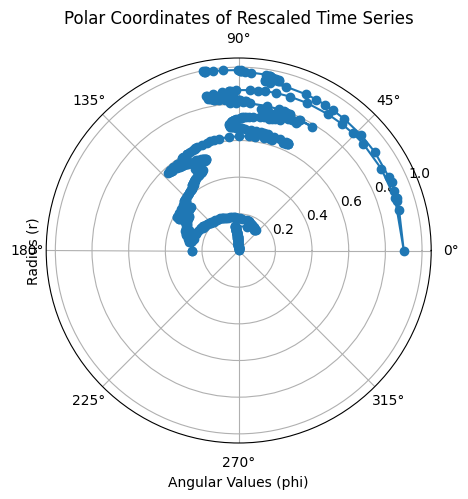

In [9]:
# taken from paper 'Generating ECG using Diffusion Models'
def rescale_time_series(X):     
    """
    Rescale the time series X to fall within the interval [-1, 1].
    
    Parameters:
    X (array-like): The input time series.
    
    Returns:
    X_rescaled (array-like): The rescaled time series.
    """
    X_min = np.min(X)
    X_max = np.max(X)
    X_rescaled = (X - X_max + (X - X_min)) / (X_max - X_min)
    return X_rescaled

X=I
X = rescale_time_series(X)
print('min',  np.min(X))
print('max',  np.max(X))

# Calculate the radius values 'r' using the time stamps
r = np.arange(1, len(X) + 1) / len(X)

# Calculate the angular values 'phi' using the rescaled time series
phi = np.arccos(X)

# Plot the polar coordinates
plt.figure(figsize=(5, 5))
plt.polar(phi, r, marker='o', linestyle='-')
plt.title('Polar Coordinates of Rescaled Time Series')
plt.xlabel('Angular Values (phi)')
plt.ylabel('Radius (r)')
plt.grid(True)
plt.show()

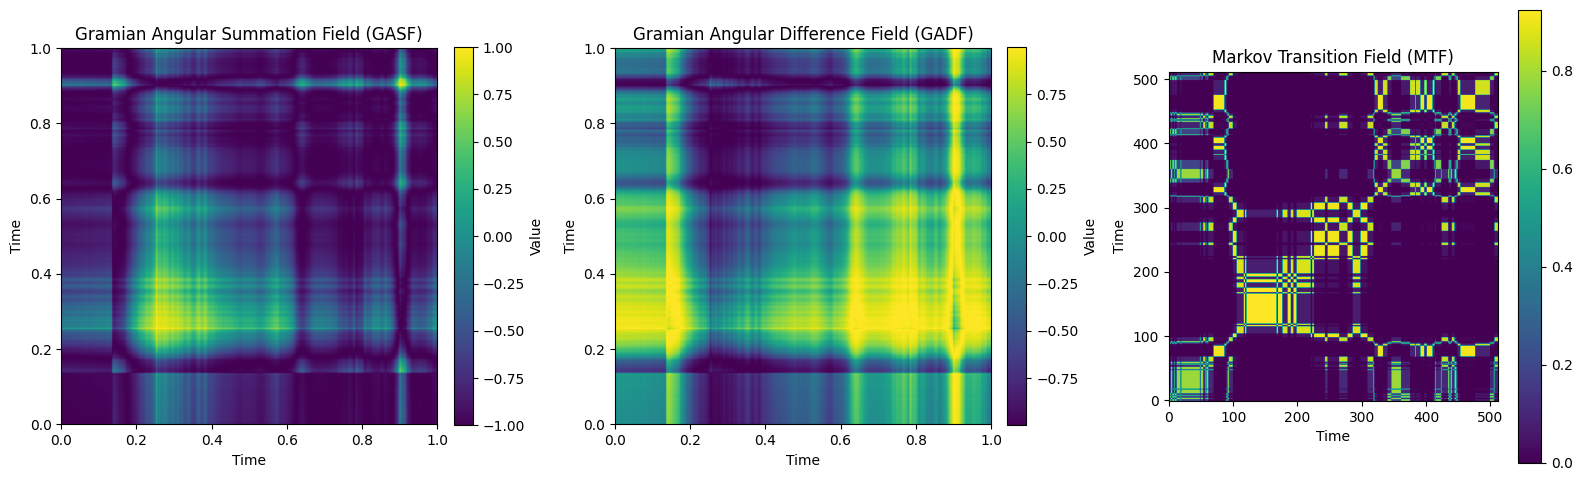

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField, MarkovTransitionField

# Right format to use GramianAngularField
X = np.array([I])

# Compute Gramian angular fields
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(X)

transformer = MarkovTransitionField()
X_new = transformer.transform(X)

# Plot the GASF
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
im = plt.imshow(X_gasf[0], origin='lower', extent=[0, len(X), 0, len(X)])
plt.title('Gramian Angular Summation Field (GASF)')
plt.xlabel('Time')
plt.ylabel('Time')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Value')

# Plot the GADF
plt.subplot(1, 3, 2)
im = plt.imshow(X_gadf[0], origin='lower', extent=[0, len(X), 0, len(X)])
plt.title('Gramian Angular Difference Field (GADF)')
plt.xlabel('Time')
plt.ylabel('Time')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Value')

# Plot the MTF
plt.subplot(1, 3, 3)
im = plt.imshow(X_new[0], origin='lower')
plt.title('Markov Transition Field (MTF)')
plt.colorbar(im)
plt.xlabel('Time')
plt.ylabel('Time')

plt.tight_layout()
plt.show()


In [11]:
from sklearn.preprocessing import MinMaxScaler
from pyts.image import GramianAngularField, MarkovTransitionField

# # Combine the techniques to convert 1D ECG into 2D Embedding (image) - 
# #   - INPUT=1D time series (one lead)
# #   - OUTPUT=2D embedding of summated GASF, GADF, MTF
gasf = GramianAngularField(method='summation')
gadf = GramianAngularField(method='difference')
transformer = MarkovTransitionField()
def ecg_to_ggm(X):
    # Rescale
    X = X.reshape(1, -1)
    X = rescale_time_series(X)
    # Compute Gramian angular fields
    X_gasf = gasf.transform(X)
    X_gadf = gadf.transform(X)
    # Compute Markov Transition Field
    X_mtf = transformer.transform(X)    
    # Combine the three matrices along the last axis
    return np.stack((X_gasf[0], X_gadf[0], X_mtf[0]), axis=-1)
    # return np.stack((X_gasf[0], X_gadf[0], np.zeros(X_gadf[0].shape)), axis=-1)
def ggm_to_ecg(ggm):
    # Extract GASF channel
    gasf_channel = ggm[:, :, 0]
    
    # Extract diagonal elements
    diagonals = np.diagonal(gasf_channel)
    
    return diagonals

# Visualizations
def plot_multiple_ggm(embeddings, names, title='ECG 2D'):
    num_embeddings = len(embeddings)

    plt.figure(figsize=(5 * num_embeddings, 5))

    for i, (embedding, name) in enumerate(zip(embeddings, names), 1):
        plt.subplot(1, num_embeddings, i)
        plt.imshow(embedding)
        plt.title(name)
        plt.xlabel('Time')
        plt.ylabel('Time')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


#### Generate Noisy Samples

Since our goal is to use a supervised learning (e.g. diffusion image restauration models). We need to build a training/test set.

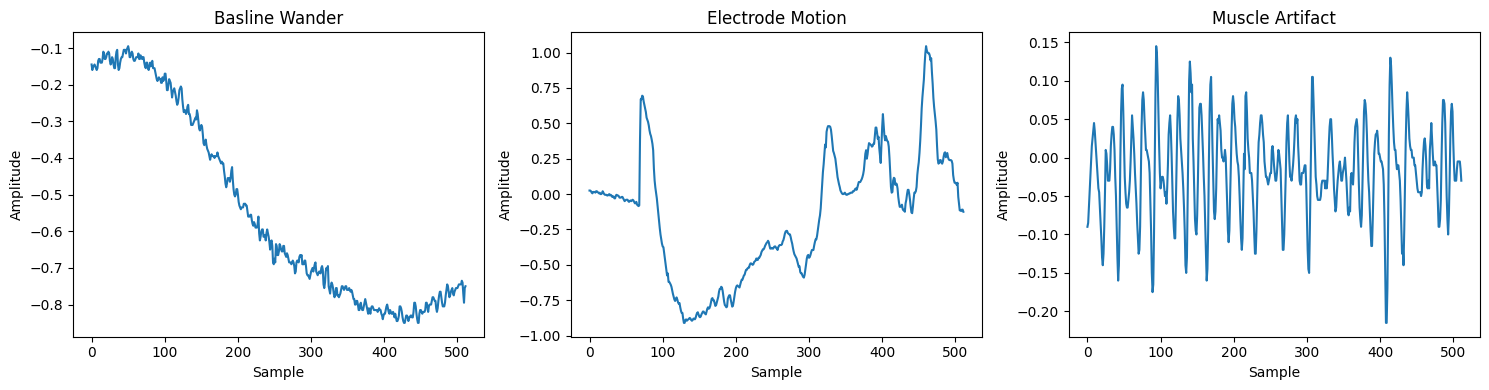

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


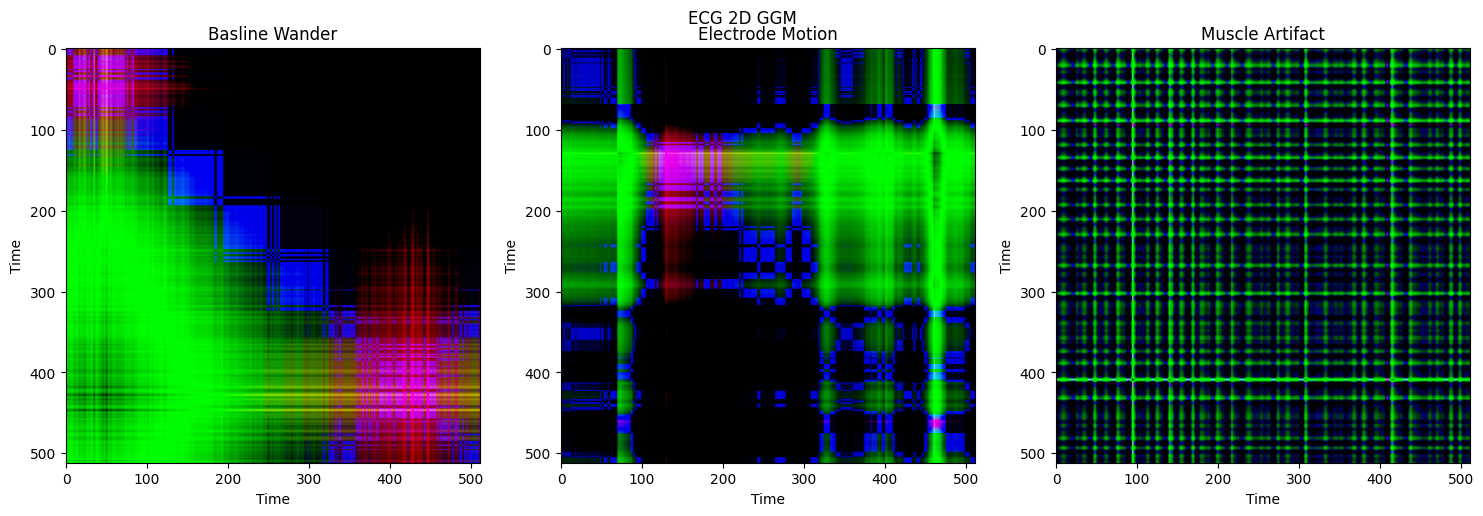

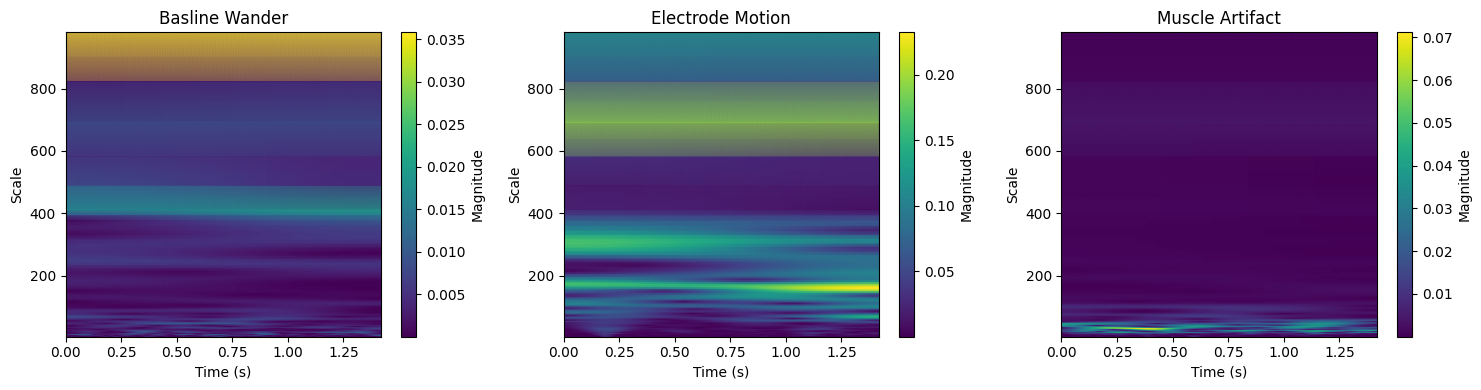

/var/folders/lx/47469rq12_q21sc9r48mg4sc0000gn/T/ipykernel_4486/902961245.py:53: RuntimeWarning: divide by zero encountered in log10
  log_magnitude = 10 * np.log10(magnitude)


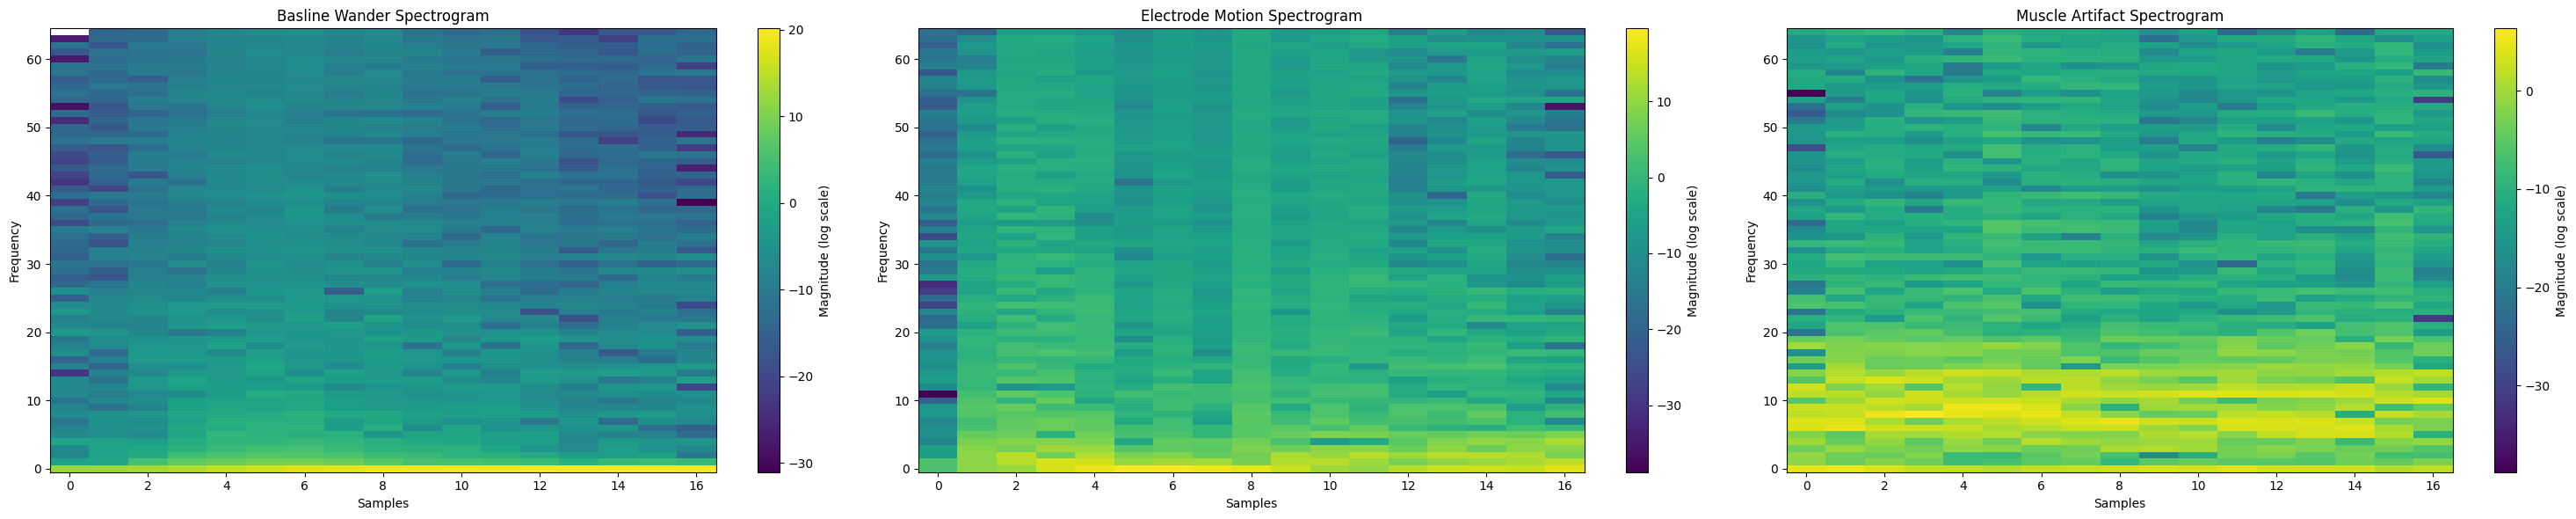

In [12]:
# Extract record
sampto=128*2*2
record_bw = wfdb.rdsamp("data/nstdb/bw", sampto=sampto); signal_bw = record_bw[0][:, 0] 
record_em = wfdb.rdsamp("data/nstdb/em", sampto=sampto); signal_em = record_em[0][:, 0]
record_ma = wfdb.rdsamp("data/nstdb/ma", sampto=sampto); signal_ma = record_ma[0][:, 0]

signals = [signal_bw,signal_em,signal_ma]
names = ['Basline Wander', 'Electrode Motion', 'Muscle Artifact']

# Plot multiple time series
plot_multiple_timeseries(signals,names)

# Plot multiple 2D Embeddings
ecg_to_ggms = [ecg_to_ggm(signal_bw), ecg_to_ggm(signal_em), ecg_to_ggm(signal_ma) ]

plot_multiple_ggm(ecg_to_ggms, names, title='ECG 2D GGM')

# Plot Multiple Scalograms
plot_multiple_scalograms([signal_bw,signal_em,signal_ma], [360,360,360], names)

# Plot Multiple Spectograms
stft_ECGs = [generate_stft(signal_bw), generate_stft(signal_em), generate_stft(signal_ma)]
plot_multiple_spectrograms(stft_ECGs,  names)

We can linearly add noise to the samples and control the $SNR$. We use the strategy used in this paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754. In addition to that, we also make a method that adds Guassian Noise.

In [13]:
def add_noise(ecg_signal, noise_signal, snr_dB):
    """
    Add noise to the clean ECG signal.

    Parameters:
    - ecg_signal (ndarray): The clean ECG signal.
    - noise_signal (ndarray): The noise signal to be added.
    - snr_dB (float): The desired signal-to-noise ratio in decibels.

    Returns:
    - noisy_signal (ndarray): The noisy ECG signal.
    """
    # Calculate lambda (λ) based on the desired SNR
    lambda_value = np.sqrt(np.mean(ecg_signal**2)) / (np.sqrt(np.mean(noise_signal**2)) * 10**(0.1 * snr_dB / 2))

    # Generate noisy signal
    noisy_signal = ecg_signal + noise_signal * lambda_value

    return noisy_signal

def add_gaussian_noise(ecg_signal, snr_dB):
    """
    Add Gaussian noise to the clean ECG signal.

    Parameters:
    - ecg_signal (ndarray): The clean ECG signal.
    - snr_dB (float): The desired signal-to-noise ratio in decibels.

    Returns:
    - noisy_signal (ndarray): The noisy ECG signal.
    """
    # Calculate the noise standard deviation based on the desired SNR
    signal_power = np.mean(ecg_signal**2)
    noise_power = signal_power / (10**(snr_dB / 10))
    noise_std = np.sqrt(noise_power)

    # Generate Gaussian noise
    noise = np.random.normal(scale=noise_std, size=ecg_signal.shape)

    # Generate noisy signal
    noisy_signal = ecg_signal + noise

    return noisy_signal

Time for an example and some visualizations!

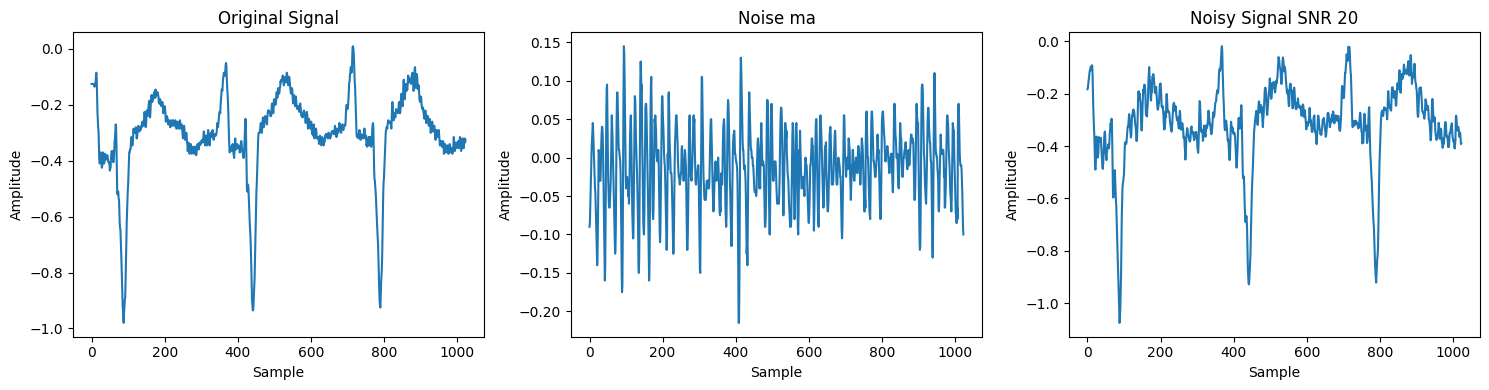

/var/folders/lx/47469rq12_q21sc9r48mg4sc0000gn/T/ipykernel_4486/902961245.py:53: RuntimeWarning: divide by zero encountered in log10
  log_magnitude = 10 * np.log10(magnitude)


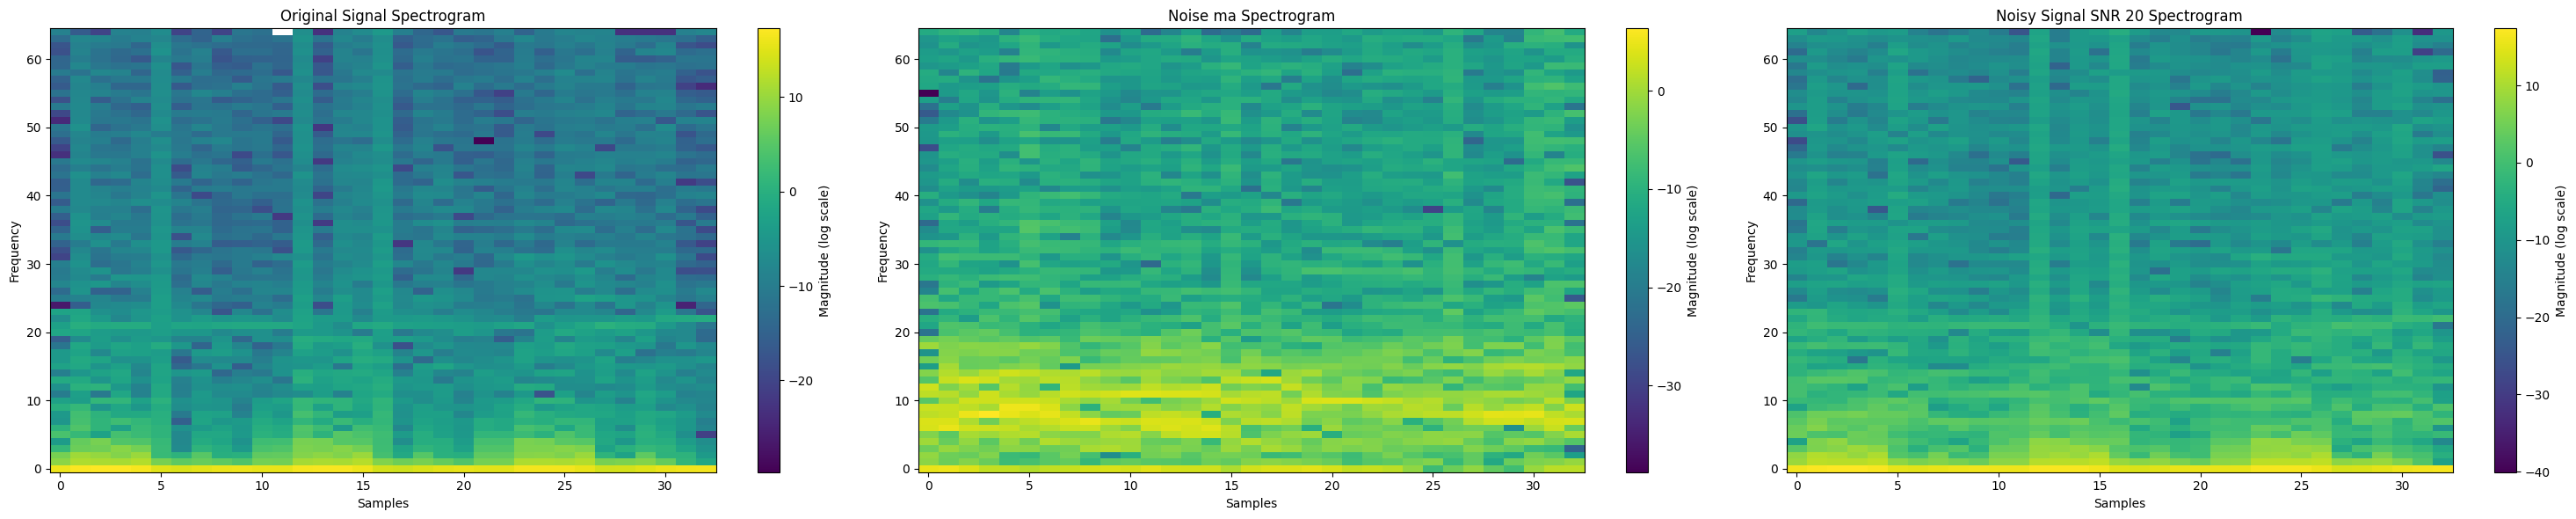

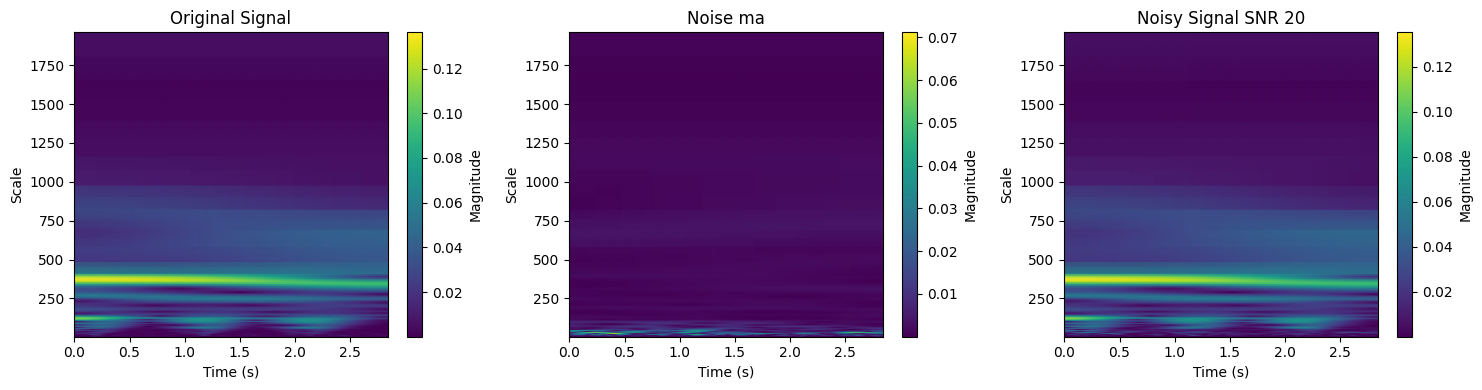

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


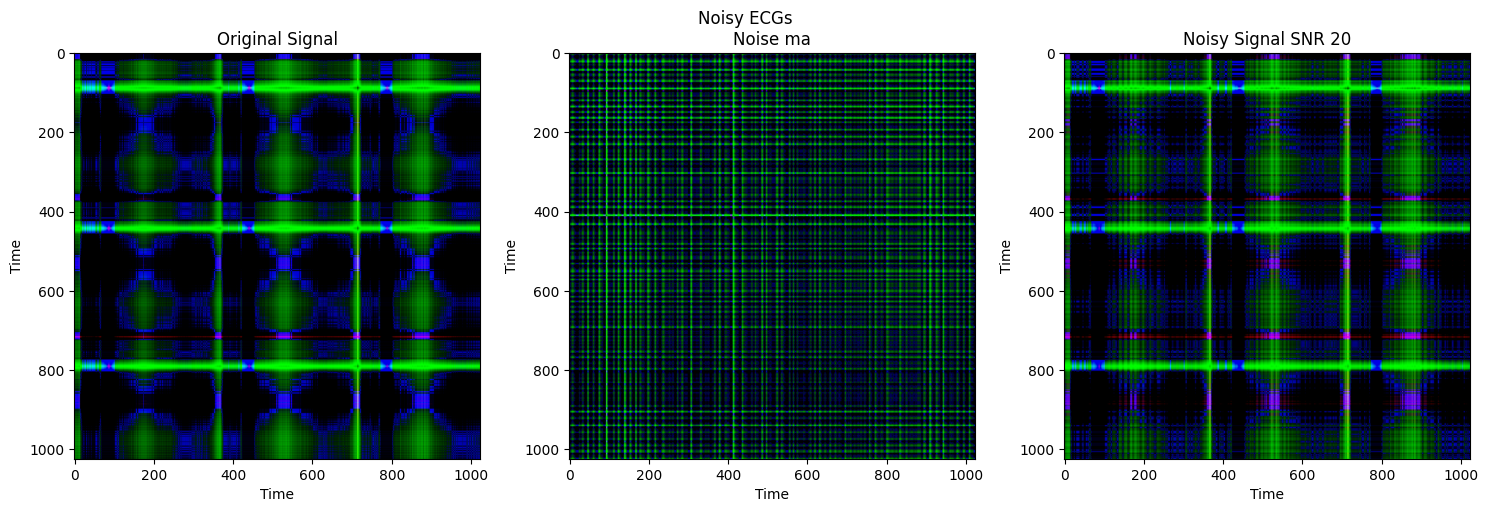

In [14]:
# Define clean ECG signal
sampto=128*2*4
record = wfdb.rdsamp("data/ardb/108", sampto=sampto)
ecg_signal = record[0][:, 0] 

# Define noise signal
path_to_noise = "data/nstdb/ma"
record_noise = wfdb.rdsamp(path_to_noise, sampto=sampto)
noise_signal = record_noise[0][:, 0] 
noise_type = path_to_noise[-2:]

# Desired signal-to-noise ratio (SNR) in decibels
snr_dB = 20  # Example SNR

# Add noise to the clean ECG signal
noisy_signal = add_noise(ecg_signal, noise_signal, snr_dB)

# Different Visualizations...
signals=[ecg_signal, noise_signal,  noisy_signal] 
names=["Original Signal", "Noise "+str(noise_type), "Noisy Signal SNR "+str(snr_dB)]

# Time Series
plot_multiple_timeseries(signals,names)

# # STFT
stft_ECGs = [generate_stft(ecg_signal), generate_stft(noise_signal), generate_stft(noisy_signal)]
plot_multiple_spectrograms(stft_ECGs, names)

# Scalogram
plot_multiple_scalograms(signals,[360,360,360],names)

# Embedding
embeded_ECGs = [ecg_to_ggm(signals[0]),ecg_to_ggm(signals[1]),ecg_to_ggm(signals[2])]
plot_multiple_ggm(embeded_ECGs,names,'Noisy ECGs')



#### Build Training- and Test Set
One paper that works with 1D CCNs uses a 3.0 sec sliding window : https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754. I do assume however, if we want to work with 2D CNNs, we will loose too much detail.

An altenative approach of researchers that used diffusion models to generate synthetic hearbeats, was to 'split up' the signal into segmeents with just individual heartbeats (https://arxiv.org/pdf/2306.01875.pdf). They did this based on 270 samples, which corresponds to 0.75 seconds, given a sampling rate of 360. However, since certain noise types can clearly affect multiple heartbeats so we might have to find a middle ground.

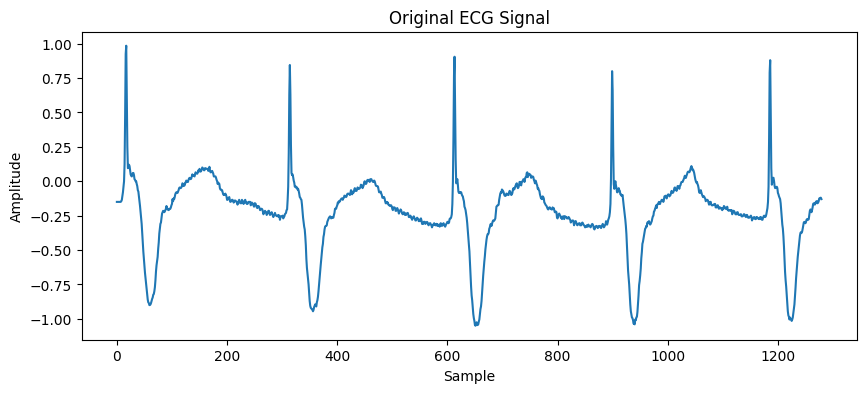

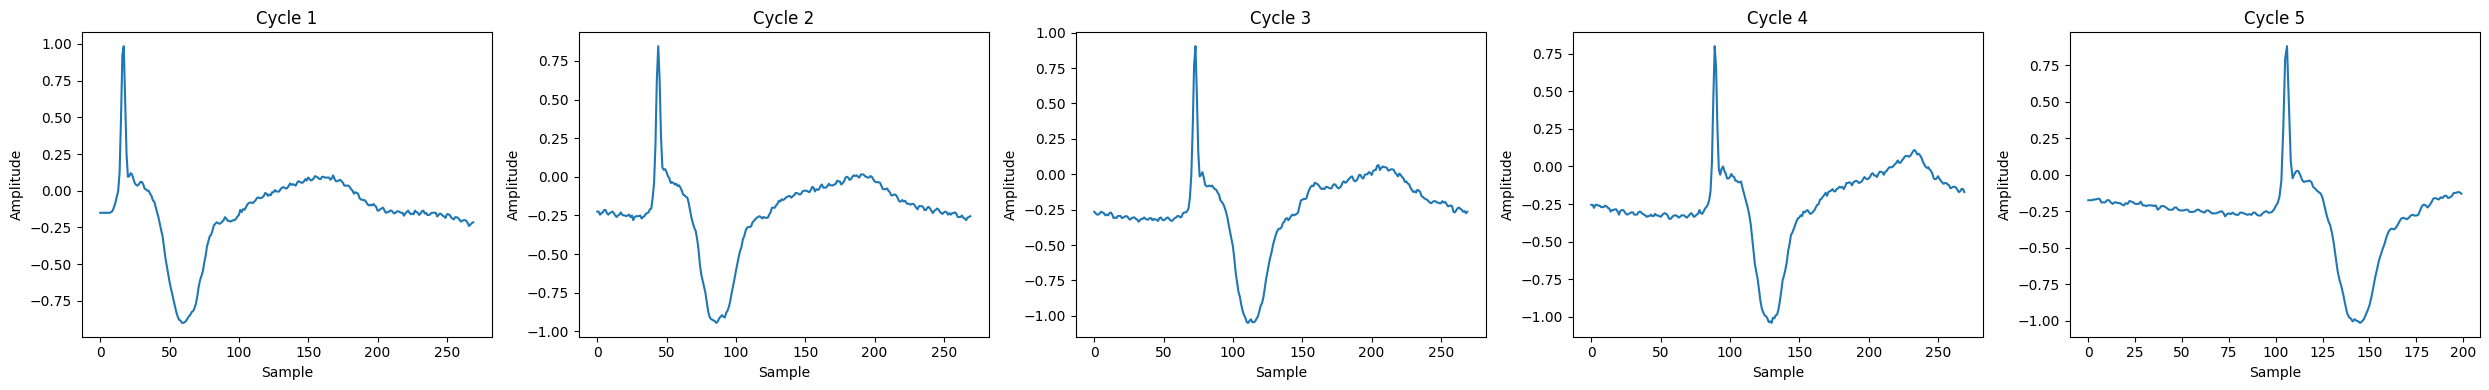

<Figure size 640x480 with 0 Axes>

In [15]:
import wfdb
import matplotlib.pyplot as plt

# Define sampto
sampto = 128 * 10

# Read the ECG signal from the record
record = wfdb.rdsamp("data/ardb/104", sampto=sampto)
ecg_signal = record[0][:, 0]

# Define the length of a cardiac cycle
cycle_length = 270 

# Split the ECG signal into cardiac cycles
cardiac_cycles = []
for i in range(0, len(ecg_signal), cycle_length):
    cycle = ecg_signal[i:i+cycle_length]
    cardiac_cycles.append(cycle)

# Plot the original ECG signal
plt.figure(figsize=(10, 4))
plt.plot(ecg_signal)
plt.title('Original ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Plot the split-up cardiac cycles
plot_multiple_timeseries(cardiac_cycles, [f'Cycle {i+1}' for i in range(len(cardiac_cycles))])

plt.tight_layout()
plt.show()


If we use $stft$ with $nFFT=128$ we might have to do paddingn. Our sample length is $650000$ and based on paper we took $270$ as an 'average' duration for an individual heartbeat.

In [16]:
# Read the ECG signal from the record
record = wfdb.rdsamp("data/ardb/104")
ecg_signal = record[0][:, 0]

def slice_ecg_signal(ecg_signal, signal_length, heartbeat_duration, k):
    k_heartbeats = heartbeat_duration * k
    parts_of_interest = signal_length // k_heartbeats
    return [ecg_signal[i * k_heartbeats : (i + 1) * k_heartbeats] for i in range(parts_of_interest)]

If we define our length/ number of heartbeats, we can slice the indivual records to obtain many smaller signals/slices.

In [17]:
# Define Variables
signal_length = 650000
heartbeat_duration = 270
k = 2

# Function to read ECG signals from .dat files and generate slices
def generate_slices(folder_path):
    # Initialize an empty dictionary to store slices
    slices_dict = {}

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.dat'):
            # Extract the record number from the file name
            record_number = file_name.split('.')[0]

            # Read the ECG signal from the .dat file
            record = wfdb.rdsamp(os.path.join(folder_path, record_number))
            ecg_signal = record[0][:, 0]

            # Generate slices
            slices = slice_ecg_signal(ecg_signal,signal_length,heartbeat_duration,k)

            # Add slices to the dictionary
            slices_dict[record_number] = slices

    return slices_dict

# Folder path containing the .dat files
folder_path = "data/ardb"

# Generate slices and create dictionary
slices_dict_clean = generate_slices(folder_path)

# Print the dictionary
for record_number, slices in slices_dict_clean.items():
    print(f"Record Number: {record_number}, Number of Slices: {len(slices)}")

Record Number: 213, Number of Slices: 1203
Record Number: 207, Number of Slices: 1203
Record Number: 212, Number of Slices: 1203
Record Number: 210, Number of Slices: 1203
Record Number: 205, Number of Slices: 1203
Record Number: 201, Number of Slices: 1203
Record Number: 215, Number of Slices: 1203
Record Number: 214, Number of Slices: 1203
Record Number: 200, Number of Slices: 1203
Record Number: 228, Number of Slices: 1203
Record Number: 202, Number of Slices: 1203
Record Number: 203, Number of Slices: 1203
Record Number: 217, Number of Slices: 1203
Record Number: 106, Number of Slices: 1203
Record Number: 112, Number of Slices: 1203
Record Number: 113, Number of Slices: 1203
Record Number: 107, Number of Slices: 1203
Record Number: 111, Number of Slices: 1203
Record Number: 105, Number of Slices: 1203
Record Number: 104, Number of Slices: 1203
Record Number: 114, Number of Slices: 1203
Record Number: 100, Number of Slices: 1203
Record Number: 101, Number of Slices: 1203
Record Numb

Since we want to build a synthetic dataset (known ground truth), we need both clean- and noisy signals. We can build a new dictionary, that contains the samples, however with noise added.

In [18]:
# Take noise signal as long as slice
record = wfdb.rdsamp("data/nstdb/ma", sampto=540)
noise_signal = record[0][:, 0]
snr = 10 

# Build the dictionary with noisy samples
def generate_noisy_samples(slices_dict, noise_sample, snr_dB):
    noisy_samples_dict = {}
    for record_number, slices in slices_dict.items():
        noisy_slices = []
        for slice in slices:
            noisy_slice = add_noise(slice, noise_sample, snr_dB)
            noisy_slices.append(noisy_slice)
        noisy_samples_dict[record_number] = noisy_slices
    return noisy_samples_dict

slices_dict_noisy = generate_noisy_samples(slices_dict_clean, noise_signal, 10)

We can use access our slices for certain records easily and both obtain the clean and noisy slices. From there on we can use our embedding methods, to feed as input to a model.

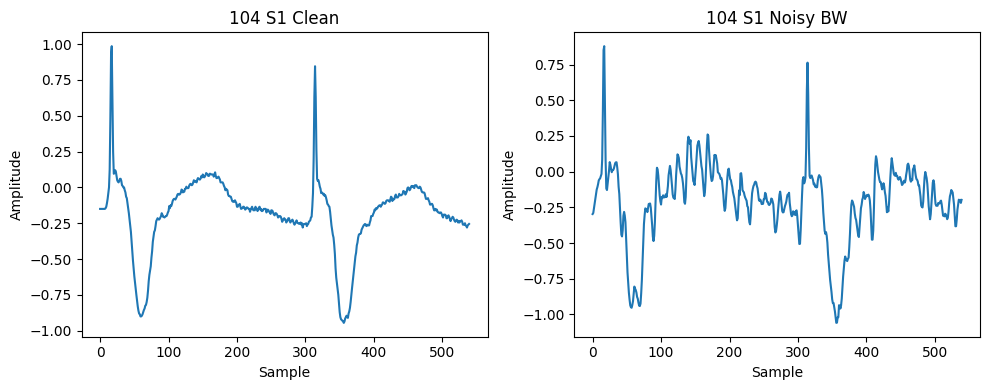

In [19]:
# Example
sig_104_clean = slices_dict_clean.get('104')[0]       # retrieve first slice clean from record 104
sig_104_noisy = slices_dict_noisy.get('104')[0]       # retreive first slice noisy from record 104

plot_multiple_timeseries([sig_104_clean, sig_104_noisy], ['104 S1 Clean', '104 S1 Noisy BW'])
# plot_multiple_ggm( [ecg_to_ggm(sig_104_clean), ecg_to_ggm(sig_104_noisy)], ['104 S1 Clean', '104 S1 Noisy AM']    )

Since we will work with Pytorch (and Tensorflow) we will convert our dictionaries and then use the library focused structure. By sorting them, we know they correspond to the same original slice.

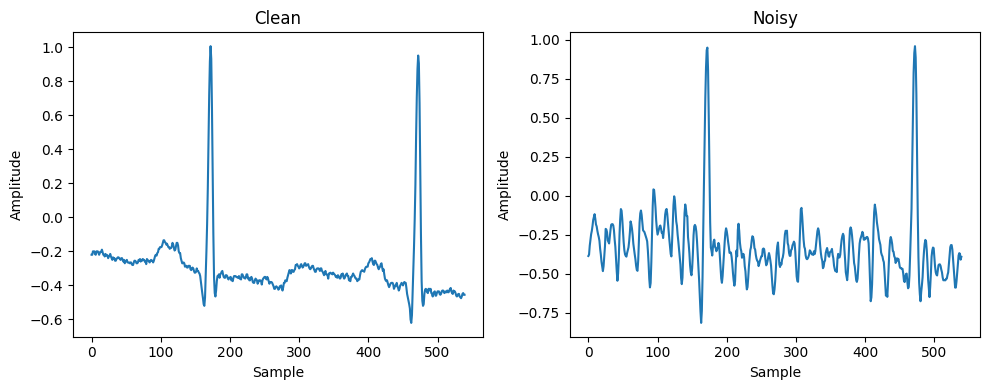

In [20]:
# Dictionaries to list
clean_slices_list = [slices_dict_clean[key] for key in sorted(slices_dict_clean.keys())]
noisy_slices_list = [slices_dict_noisy[key] for key in sorted(slices_dict_noisy.keys())]

# Flatten
clean_slices_flat = [slice for sublist in clean_slices_list for slice in sublist]
noisy_slices_flat = [slice for sublist in noisy_slices_list for slice in sublist]

plot_multiple_timeseries([clean_slices_flat[1000],noisy_slices_flat[1000]],['Clean', 'Noisy'])

# Since we have our clean data (ground truth) and noisy data, we can now create the train-(validation) and test sets.
# create a train / validation / test set to use with pytorch and/or tensorflow.. so i can train my model 

Since we have our clean data (ground truth) and noisy data, we can now create the train-(validation) and test sets.

In [21]:
from sklearn.model_selection import train_test_split

# Train and test-set 
X_train, X_test, y_train, y_test = train_test_split(clean_slices_flat, noisy_slices_flat, test_size=0.2, random_state=42)

print(type(X_train))
print(' Number of samples', len(X_train))

<class 'list'>
 Number of samples 46195


### Part 2: Models

- embeddings
- diffusion models?!

#### Embeddings
Depending on the model we want to use, we might require to embed the 1D timeseries data into a suitable 2D image-like representation. This allows use to use a wide-array of different models from the image processing and computer-vision domain. 

In [22]:
import pickle
from tqdm import tqdm

# Embed list of ECG signals 
def embed_data(data, embedding='spec', save=False, save_path=None):
    embeddings = []
    desc = "Embedding Spectrograms" if embedding == 'spec' else "Embedding GGMs" if embedding == 'ggm' else "Embedding Scalograms"
    for signal in tqdm(data, desc=desc):
        if embedding == 'spec':
            spectrogram = ecg_to_spectrogram(signal)
            embeddings.append(spectrogram)
        elif embedding == 'ggm':
            ggm = ecg_to_ggm(signal)
            embeddings.append(ggm)
        elif embedding == 'scal':
            scalogram = ecg_to_scalogram(signal)
            embeddings.append(scalogram)
    
    if save:
        if save_path is None:
            raise ValueError("Please provide a valid path to save the embeddings.")
        with open(save_path, 'wb') as f:
            pickle.dump(embeddings, f)
        print(f"Embeddings saved to {save_path}")

    return embeddings

# Example usage with saving
embedded_data = embed_data(data, embedding='spec', save=True, save_path='embeddings.pkl')
